In [46]:
import numpy as np
import pandas as pd
from collections import Counter
import ast

import umap
import numba
from scipy.sparse import dok_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os
import sys

sys.path.append("../src")
sys.path.append("../../gutenberg/src")
from metaquery import meta_query
from data_io import get_dict_words_counts

### Using UMAP with a precomputed distance matrix
This is the simple approach but computing and storing a $50k \times 50k$ matrix is no joke.

### Using UMAP with a custom distance function
Here we let UMAP handle the distances efficiently. Instead we need to pass:
+ a **sparse** samples-features matrix
+ a numba-jitted custom distance function

Our features are word types, so the only way to hold the samples-features matrix is with sparse matrices. 

In [47]:
@numba.njit()
def D_alpha_max(H1,H2,pi1,pi2,alpha=1.0):
    '''The maximum Jensen-Shanon-divergence of two probability distributions p1 and p2
    with entropies H1 and H2 and weights pi1 and pi2.
    The maximum jsd is obtained by assuming the support of both distributions is disjunct.
    For more information see:
    Gerlach, Font-Clos, Altmann, Phys. Rev. X 6 (2016) 021009
    https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.021009

    INPUT:
    - H1, float, alpha-entropy of p1
    - H2, float, alpha-entropy of p2
    - pi1, float, weight given to p1
    - pi2, float, weight given to p2
    optional
    - alpha, float (default:1.0)

    OUTPUT:
    - D_max, float - maximum JSD
    '''
    D_max = 0.0
    if alpha == 1.0:
        D_max = -pi1*np.log(pi1)-pi2*np.log(pi2)
    else:
        D_max = (pi1**alpha-pi1)*H1+\
                (pi2**alpha-pi2)*H2+\
                1.0/(1.0-alpha)*(pi1**alpha+pi2**alpha-1)
    return D_max

@numba.njit()
def H_alpha_sparse_csr(arr_p,alpha=1.0):
    '''Calculate generalized entropy of order-alpha
        H_{\alpha}(\vec{p}) = \frac{1}{1-\alpha}( \sum_i p_i^{\alpha} - 1  )
        https://en.wikipedia.org/wiki/Tsallis_entropy

        INPUT:
        - arr_p, array (normalized probability distribution)
        optional
        - alpha, float (default:1.0 == Boltzmann-Shannon-Gibbs entropy)
        OUT:
        - H_alpha, float

        Note that we have to consider special cases 
        - alpha=0; if p_i=0: p_i^0=0 and p_i>0: p_i^0=1  
        - alpha=1; H --> -\sum_i p_i log(p_i) and 0*log(0) = 0
    '''
    ## consider only entries with p>0
    arr_p_pos = arr_p
    H = 0.0
    if alpha == 0.0:
        H = len(arr_p_pos) - 1
    elif alpha == 1.0:
        H = -np.sum(arr_p_pos*np.log(arr_p_pos))
    else:
        H = 1.0/(1.0-alpha)*(np.sum(arr_p_pos**alpha) - 1.0)
    return H

def D_alpha_sparse_csr(arr_p1,arr_p2,alpha=2.0,pi1=0.5,normalized=True):
    '''
    Generalized Jensen-Shannon divergence proposed in:
        Gerlach, Font-Clos, Altmann, Phys. Rev. X 6 (2016) 021009
        https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.021009

    quantifying the divergence between probability distributions p1 and p2

    INPUT:
    - p1, array  
    - p2, array
    optional
    - alpha, float (default:1)
    - pi1, float (default:0.5); weight given to p1 (pi2 = 1-pi1)
    - normalized (default:False); if True return normalized version of alpha-JSD

    OUTPUT:
    - JSD, float

    Note that p1 and p2 have to be defined over the SAME support, i.e.
    for any index i the probabilities p1[i] and p2[i] refer to the same symbol.
    If, for example a symbol j only appears in p1, then p1[j]>0 and p2[j]=0 (and vice versa)
    '''

    pi2 = 1.0-pi1

    H_1 = H_alpha_sparse_csr(arr_p1.data,alpha=alpha)
    H_2 = H_alpha_sparse_csr(arr_p2.data,alpha=alpha)
    arr_p12 = pi1*arr_p1 + pi2*arr_p2
    H_12 = H_alpha_sparse_csr(arr_p12.data,alpha=alpha)

    D = H_12 - pi1*H_1 - pi2*H_2

    if normalized == False:
        norm = 1.0
    else:
        norm = D_alpha_max(H_1,H_2,pi1,pi2,alpha=alpha)
    D /= norm
    return D

In [48]:
def get_w_f(path_to_counts):
    """
    Reads a counts file, returns types and frequencies
    """
    w_c_dict = get_dict_words_counts(path)
    if len(w_c_dict)==0:
        return [],[]
    w, c = np.array(list(w_c_dict.items())).T
    c = c.astype(int)
    L = np.sum(c)
    if not isinstance(w,(list,np.ndarray)):
        w=[w]
        c=[c]
    return w, c/L


### Best tag definition
We don't like overlapping labels. One possible solution is to reduce to the most popular tag of each book.

In [49]:
meta = meta_query(path="../../gutenberg/metadata/metadata.csv")
tags = meta.df.subjects.replace("set()",np.nan).dropna().apply(lambda x:ast.literal_eval(x))
subject_counts = meta.get_subjects_counts()
meta.df["best_tag"] = tags.apply(lambda x:sorted([[subject_counts[s], s] for s in x])[-1][1])
meta.df = meta.df.loc[meta.df.best_tag.dropna().index]
meta.df = meta.df.loc[meta.df.best_tag.apply(lambda x:len(x)>0)]
meta.df_original = meta.df.copy()

Here we choose a few subject. We skip the most popular ones as they are too common.

In [54]:
meta.reset()
meta.filter_lang("en")
subjects = meta.df.best_tag.value_counts().index[5:10]

In [55]:
paths = []
subs = []
years = []
for i, subject in enumerate(subjects):
    meta.reset()
    meta.filter_lang("en", how="only")
    meta.df = meta.df.loc[meta.df.best_tag == subject]
    mydf = meta.df.sample(min(200,len(meta.df)))
    ids = mydf.id.values
    syears = mydf.authoryearofbirth.values
    spaths = ["../../gutenberg/data/counts/"+idd+"_counts.txt" for idd in ids]
    spaths, syears = np.array([[path, year] for path, year in zip(spaths, syears) if os.path.isfile(path)]).T
    paths.append(spaths)
    subs.append([i]*len(spaths))
    years.append(syears)

In [56]:
years = np.concatenate(years)
subs = np.concatenate(subs)
paths = np.concatenate(paths)

In [57]:
len(years)

947

In [58]:
!rm /tmp/PGtmp.txt

for path in paths:
    ! cat {path} >> /tmp/PGtmp.txt

In [59]:
with open("/tmp/PGtmp.txt",'r') as f:
    x=f.readlines()
W = list(set([xx.split("\t")[0] for xx in x]))

In [60]:
M = dok_matrix((len(paths),len(W)))
# initialize map from words to integers
w_idx = {v:k for k,v in dict(enumerate(W)).items()}

In [61]:
for d, path in enumerate(paths):
    w, f = get_w_f(path)
    
    # add words to sparse matrix
    for word,freq in zip(w, f):
        M[d,w_idx[word]] = freq

In [62]:
MM = M.tocsr()

In [63]:
u25 = umap.UMAP(n_neighbors=25, metric=D_alpha_sparse_csr).fit_transform(MM)
u10 = umap.UMAP(n_neighbors=10, metric=D_alpha_sparse_csr).fit_transform(MM)

In [64]:
import matplotlib.cm as cm

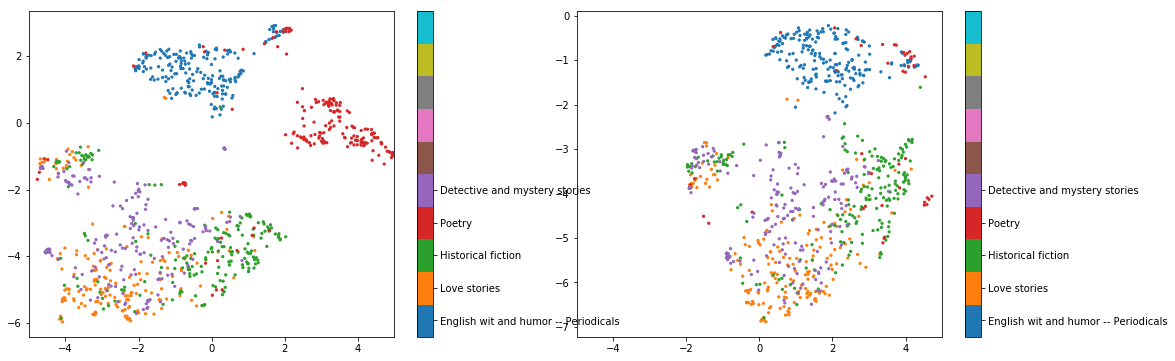

In [68]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6
                                   ))

for ax, u in zip([ax1, ax2],[u10, u25]):
    sc=ax.scatter(*u.T, s=5, c=subs, cmap=plt.cm.get_cmap("tab10"), vmin=-0.5, vmax=9.5)
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_ticks(range(len(set(subs))))
    cbar.set_ticklabels(subjects)
    ax.set_xlim(-5, 5)